# Introduction

In this project, we practice named entity recognition in 4 different languages: English, Spanish, Chinese and Japanese with the assistance of Meta AI's XLM-R model. We find that cross lingual transfer learning attains much better performances among western languages than their oriental counterparts. Fine-tuning on all languages has improved the performance of the model on almost all languages except English. Possible explanations are also provided. This project is based on the chapter 4 of the book Natural Language Processing with Transformers [1].

# Preparing Environment

Install all the necessary packages and hide the outputs.

In [ ]:
! pip install -q datasets transformers seqeval matplotlib
import warnings
warnings.simplefilter('ignore')

     |████████████████████████████████| 451 kB 4.8 MB/s 
     |████████████████████████████████| 5.5 MB 78.9 MB/s 
     |████████████████████████████████| 43 kB 1.5 MB/s 
     |████████████████████████████████| 115 kB 71.2 MB/s 
     |████████████████████████████████| 212 kB 62.8 MB/s 
     |████████████████████████████████| 182 kB 82.6 MB/s 
     |████████████████████████████████| 127 kB 83.1 MB/s 
     |████████████████████████████████| 7.6 MB 88.9 MB/s 


In [ ]:
warnings.filterwarnings("ignore")

# Load Dataset and EDA

According to HuggingFace's website [2]:
> The Cross-lingual Natural Language Inference (XNLI) corpus is a crowd-sourced collection of 5,000 test and 2,500 dev pairs for the MultiNLI corpus. The pairs are annotated with textual entailment and translated into 14 languages: French, Spanish, German, Greek, Bulgarian, Russian, Turkish, Arabic, Vietnamese, Thai, Chinese, Hindi, Swahili and Urdu. This results in 112.5k annotated pairs. Each premise can be associated with the corresponding hypothesis in the 15 languages, summing up to more than 1.5M combinations. The corpus is made to evaluate how to perform inference in any language (including low-resources ones like Swahili or Urdu) when only English NLI data is available at training time.

Take a look to see what is available inside the "xtreme" datasets. We see that most of them are language datasets and each dataset is suffixed with two letters in short. Cross lingual corpus such as "XNLI" is also available.

In [ ]:
from datasets import get_dataset_config_names, get_dataset_infos, get_dataset_split_names

xtreme_subsets = get_dataset_config_names('xtreme')
xtreme_subsets[:10]
# a list of names

['XNLI',
 'tydiqa',
 'SQuAD',
 'PAN-X.af',
 'PAN-X.ar',
 'PAN-X.bg',
 'PAN-X.bn',
 'PAN-X.de',
 'PAN-X.el',
 'PAN-X.en']

Extract the language sub-datasets. Since they always begin with "PAN", we can use the python string method "startswith" to save them in one container list.

In [ ]:
panx_subsets = [s for s in xtreme_subsets if s.startswith('PAN')]
panx_subsets[:5]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg', 'PAN-X.bn', 'PAN-X.de']

Load English and Chinese datasets. They are representatives of Western and Eastern languages. We will train on them and evaluate the model's performances on themselves and Spanish and Japanese.

In [ ]:
from datasets import load_dataset
td = load_dataset('xtreme', name='PAN-X.en')

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Check what a row in the dataset looks like. We notice that it contains tokens, ner_tags and langs (the type of language).

In [ ]:
td['train'][0]

{'tokens': ['R.H.',
  'Saunders',
  '(',
  'St.',
  'Lawrence',
  'River',
  ')',
  '(',
  '968',
  'MW',
  ')'],
 'ner_tags': [3, 4, 0, 3, 4, 4, 0, 0, 0, 0, 0],
 'langs': ['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en']}

Load all 4 different languages' dataset that we will train our model on. Since we have 2 categories of segregations: language and split, it is more convenient to use default dictionaries. To maintain equality, we also sample each of them with the sample proportion 1/4. Each of the dataset we are sampling from are also equal-sized in the original database.

In [ ]:
from collections import defaultdict
from datasets import DatasetDict

langs = ['en', 'es', 'zh', 'ja']

fracs = [0.25, 0.25, 0.25, 0.25]

panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
  ds = load_dataset('xtreme', name=f'PAN-X.{lang}')
  for split in ds:
    panx_ch[lang][split] = (
        ds[split]
        .shuffle(seed=0)
        .select(range(int(frac * ds[split].num_rows)))
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.es/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.zh/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.ja/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Check the generated dataset to see if they are equal-sized for every language.

In [ ]:
import pandas as pd
pd.DataFrame({lang: [panx_ch[lang]['train'].num_rows] for lang in langs},
             index=['number of training examples'])

,en,es,zh,ja
number of training examples,5000,5000,5000,5000


Then we write a function to use `tags` as a Classlabel to convert label ids into word-labels, and add it to the original data as `'ner_tags_str'`.

In [ ]:
tags = panx_ch['en']['train'].features['ner_tags'].feature
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [ ]:
def create_tag_names(batch):
  return {'ner_tags_str': [tags.int2str(idx) for idx in batch['ner_tags']]}

panx_en = panx_ch['en'].map(create_tag_names)
panx_es = panx_ch['es'].map(create_tag_names)
panx_zh = panx_ch['zh'].map(create_tag_names)
panx_ja = panx_ch['ja'].map(create_tag_names)

  0%|          | 0/5000 [00:00<?, ?ex/s]

  0%|          | 0/2500 [00:00<?, ?ex/s]

  0%|          | 0/2500 [00:00<?, ?ex/s]

  0%|          | 0/5000 [00:00<?, ?ex/s]

  0%|          | 0/2500 [00:00<?, ?ex/s]

  0%|          | 0/2500 [00:00<?, ?ex/s]

  0%|          | 0/5000 [00:00<?, ?ex/s]

  0%|          | 0/2500 [00:00<?, ?ex/s]

  0%|          | 0/2500 [00:00<?, ?ex/s]

  0%|          | 0/5000 [00:00<?, ?ex/s]

  0%|          | 0/2500 [00:00<?, ?ex/s]

  0%|          | 0/2500 [00:00<?, ?ex/s]

Now we can check a few examples after the conversion.

In [ ]:
en_example = panx_en["train"][2]
pd.DataFrame([en_example["tokens"], en_example["ner_tags_str"]],
['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11,12
Tokens,Vaivara,concentration,camp,",",Vaivara,(,''1943–1944,",",during,German,occupation,'',)
Tags,B-LOC,I-LOC,I-LOC,O,B-LOC,O,O,O,O,B-ORG,I-ORG,O,O


We also find some of the rows contain more than one language, for instance the following all tokens are marked with Chinese, but obviously three Korean characters are also present. We are not sure how this would affect the training results.

In [ ]:
zh_example = panx_zh["train"][50]
pd.DataFrame([zh_example["tokens"], zh_example["ner_tags_str"]],
['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Tokens,朴,明,洙,#,(,박,명,수,),#,...,0,0,7,年,7,月,5,日,至,今
Tags,B-PER,I-PER,I-PER,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


We also need to check if the labels are balanced or not. It turns out that 'ORG', 'PER' and 'LOC' labels are almost equally distributed across splits, which is desirable.

In [ ]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_en.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1] #extract label at position 1
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,ORG,PER,LOC
train,2363,2284,2226
validation,1177,1186,1212
test,1141,1164,1219


# Initiate Models

According to Meta AI's [post](https://ai.facebook.com/blog/-xlm-r-state-of-the-art-cross-lingual-understanding-through-self-supervision/) [2]:
> XLM-R uses self-supervised training techniques to achieve state-of-the-art performance in cross-lingual understanding, a task in which a model is trained in one language and then used with other languages without additional training data. The model improves upon previous multilingual approaches by incorporating more training data and languages — including so-called low-resource languages, which lack extensive labeled and unlabeled datasets.

> XLM-R has achieved the best results to date on four cross-lingual understanding benchmarks, with increases of 4.7 percent average accuracy on the XNLI cross-lingual natural language inference dataset, 8.4 percent average F1 score on the recently introduced MLQA question answering dataset, and 2.1 percent F1 score on NER. After extensive experiments and ablation studies, we’ve shown that XLM-R is the first multilingual model to outperform traditional monolingual baselines that rely on pretrained models.

In [ ]:
from transformers import AutoTokenizer

xlmr_model_name = 'xlm-roberta-base'
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

We use RoBERTa as the base model and add the settings specific to XLM-R. To begin with we need a `config` to initialize the model and a `forward()` function to generate the outputs. The hidden state is fed through the dropout and classification layers. If labels' info are given, we can use it to calculate the loss. If attention is also provided we need to make sure we only calculate the loss from unmasked tokens. Lastly, we return all the outputs in a `TokenClassifierOutput` object.

In [ ]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel, RobertaPreTrainedModel

In [ ]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  config_class = XLMRobertaConfig

  def __init__(self, config):
    super().__init__(config)
    self.num_labels = config.num_labels
    self.roberta = RobertaModel(config, 
                                # all hidden layers are return
                                # not just [cls]
                                add_pooling_layer=False
                                )
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    self.init_weights()

  def forward(self, input_ids=None, attention_mask=None, 
              token_type_ids=None, labels=None, **kwargs):
    outputs = self.roberta(input_ids, attention_mask=attention_mask,
                           token_type_ids=token_type_ids, **kwargs)
    sequence_output = self.dropout(outputs[0])
    logits = self.classifier(sequence_output)
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    return TokenClassifierOutput(loss=loss, logits=logits,
                                 hidden_states=outputs.hidden_states,
                                 attentions=outputs.attentions)


Before we load our model, we also need to provide the tags that we will use to label each entity and the mappings dict between tags and IDs.

In [ ]:
tags.names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [ ]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [ ]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag,
                                         label2id=tag2index)

We load the model with `from_pretrained()` function and the `config` argument. All the pretrained weights in the custom model are inherited from `RobertaPreTrainedModel`.

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['roberta.embeddings.position_

We write a helper function to help us see align the tokens and tags.

In [ ]:
def tag_text(text, tags, model, tokenizer):
    # get tokens with special characters
    tokens = tokenizer(text).tokens()
    # encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

# Tokenizing Texts

We also need a helper function to tokenize the dataset and add labels to it.

In [ ]:
def tokenize_and_align_labels(examples):
  # truncation=True is needed
  tokenized_inputs = xlmr_tokenizer(examples['tokens'], truncation=True, 
                                    is_split_into_words=True)
  labels = []
  for idx, label in enumerate(examples['ner_tags']):
    # here batch_index is needed
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
        if word_idx is None or word_idx == previous_word_idx:
            label_ids.append(-100)
        else:
            label_ids.append(label[word_idx])
        previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs["labels"] = labels
  return tokenized_inputs

Test it on two examples, we see it is really working.

In [ ]:
tokenize_and_align_labels(panx_en["train"][2:4])

{'input_ids': [[0, 9079, 7113, 202104, 11491, 6, 4, 9079, 7113, 15, 5106, 210298, 1104, 151210, 6, 4, 20271, 30839, 6, 167618, 5106, 1388, 2], [0, 1650, 83, 14037, 23, 32969, 136, 192777, 6, 5, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[-100, 5, -100, 6, 6, 0, -100, 5, -100, 0, 0, -100, -100, -100, 0, -100, 0, 3, 4, -100, 0, 0, -100], [-100, 0, 0, 0, 0, 5, 0, 5, 0, -100, -100]]}

Since we have multiple datasets to work with, let's write a function to automate the tokenization process. 

In [ ]:
def encode_panx_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True, 
                    remove_columns=['langs', 'ner_tags', 'tokens'])
  
panx_en_encoded = encode_panx_dataset(panx_ch['en'])
panx_es_encoded = encode_panx_dataset(panx_ch['es'])
panx_zh_encoded = encode_panx_dataset(panx_ch['zh'])
panx_ja_encoded = encode_panx_dataset(panx_ch['ja'])

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

# Performances Measures

Similar to evaluating a test classification model, while evaluating NER model we need to report results for precision, recall and F1-score. However for a prediction to be counted as correct, ALL words of an entity need to be predicted correctly. The `seqeval` is designed for this kind of task. It only takes input as lists. We can write a function to convert the model outputs into lists as expected by the `seqeval`.

In [ ]:
from seqeval.metrics import classification_report
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

# Fine-tune Model

## Fine-tune on English dataset.

In [ ]:
from transformers import TrainingArguments

In [ ]:
num_epochs = 3
batch_size = 24

# why design logging_steps in this way?
logging_steps = len(panx_en_encoded["train"]) // batch_size

model_name = f'{xlmr_model_name}-finetuned-panx-en'

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    log_level='error',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy='epoch',
    save_steps=1e6, 
    weight_decay=0.01, 
    disable_tqdm=False,
    logging_steps=logging_steps,
)


We also need to specify how the validation metrics (F1 score) are calculated using the `align_predictions()` function.

In [ ]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions,
                                     eval_pred.label_ids)
  return {'f1': f1_score(y_true, y_pred)}

The last step is to create a data collator for padding each input sequence to the largest sequence length in a batch with -100 which will be ignored by PyTorch loss functions.

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

We also need to disable parallelism to avoid deadlocks, then we initiate the model and trainer.

In [ ]:
def model_init():
  return (XLMRobertaForTokenClassification.from_pretrained(
      xlmr_model_name, config=xlmr_config).to(device))

In [ ]:
%env TOKENIZERS_PARALLELISM=false
from transformers import Trainer

trainer = Trainer(model_init=model_init,
                  args=training_args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  train_dataset=panx_en_encoded['train'],
                  eval_dataset=panx_en_encoded['validation'],
                  tokenizer=xlmr_tokenizer)

env: TOKENIZERS_PARALLELISM=false


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.588900,0.386111,0.708733
2,0.302200,0.350407,0.755940
3,0.214600,0.330255,0.771613


TrainOutput(global_step=627, training_loss=0.3679613072716258, metrics={'train_runtime': 57.4083, 'train_samples_per_second': 261.286, 'train_steps_per_second': 10.922, 'total_flos': 283487133333888.0, 'train_loss': 0.3679613072716258, 'epoch': 3.0})

We can also see if the model works on a toy example.

In [ ]:
text_en = "Taylor Swift is a famous singer-songwriter in the United States."
tag_text(text_en, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Tokens,<s>,▁Taylor,▁Swift,▁is,▁an,▁famous,▁sing,er,-,song,writer,▁in,▁the,▁United,▁States,.,</s>
Tags,O,B-PER,I-PER,O,O,O,O,O,O,O,O,O,O,B-LOC,I-LOC,O,O


## Fine-tune on Chinese dataset

In [ ]:
logging_steps = len(panx_zh_encoded["train"]) // batch_size

model_name = f'{xlmr_model_name}-finetuned-panx-zh'

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    log_level='error',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy='epoch',
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps,
)

In [ ]:
trainer_zh = Trainer(model_init=model_init,
                  args=training_args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  train_dataset=panx_zh_encoded['train'],
                  eval_dataset=panx_zh_encoded['validation'],
                  tokenizer=xlmr_tokenizer)

trainer_zh.train()

Epoch,Training Loss,Validation Loss,F1
1,0.518600,0.312805,0.593358
2,0.296200,0.277953,0.656150
3,0.212400,0.249451,0.685547


TrainOutput(global_step=627, training_loss=0.3414476397410154, metrics={'train_runtime': 185.3926, 'train_samples_per_second': 80.909, 'train_steps_per_second': 3.382, 'total_flos': 1722758397264960.0, 'train_loss': 0.3414476397410154, 'epoch': 3.0})

# Error Analysis

"We might accidentally mask too many tokens and also mask some of our labels to get a really promising loss drop. The `compute_metrics()` function might have a bug that overestimates the true performance. We might include the zero class or 0 entity in NER as a normal class which will heavily skew the accuracy and F1-score since it is the majority class by a large margin." - cited from *Natural Lanuage Processing with Transformers* 

Below, we create a function to add add loss and predicted labels to the data.

In [ ]:
from torch.nn.functional import cross_entropy

# add loss and predicted label to the df
def forward_pass_with_label(batch):
    # convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # pass data through model  
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), 
                         labels.view(-1), reduction="none")
    # unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

Then we map all elements with the `forward_pass_with_label` function and covert the dataset to pandas format.

In [ ]:
valid_set = panx_en_encoded['validation']
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)

df = valid_set.to_pandas()
df[:3]

  0%|          | 0/79 [00:00<?, ?ba/s]

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 111767, 87, 1529, 5861, 1650, 194397, 70, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 3, 4, -100, 4, 4, 4, 4, -100, -100, ...","[0.0, 0.0020447315, 0.019795012, 0.01212288, 0...","[4, 0, 3, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, ..."
1,"[0, 2161, 7071, 496, 6, 4, 423, 11591, 6, 4, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 0, 0, 0, -100, 0, -100, 0, -100, 1, ...","[0.0, 0.0006899837, 0.0034079826, 0.0011492322...","[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, ..."
2,"[0, 152, 46294, 9239, 9, 1234, 6, 4, 25134, 26...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 5, -100, -100, -100, 0, -100, 5, 6, ...","[0.0, 0.0012986568, 0.058232415, 0.0, 0.0, 0.0...","[6, 0, 5, 6, 6, 6, 0, 0, 5, 6, 6, 6, 6, 6, 6, ..."


After the dataset is available, we add new columns: input_tokens, predicted_label, labels, loss, predicted_label to it.

In [ ]:
index2tag[-100] = 'IGN' # convert -100 to 'IGN'
df['input_tokens'] = df['input_ids'].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x)
)
df['predicted_label'] = df['predicted_label'].apply(
    lambda x: [index2tag[i] for i in x]
)
df['labels'] = df['labels'].apply(
    lambda x: [index2tag[i] for i in x]
)
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1
)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)

In [ ]:
df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 111767, 87, 1529, 5861, 1650, 194397, 70, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, O, B-ORG, I-ORG, IGN, I-ORG, I-ORG, I-OR...","[0.0, 0.0020447315, 0.019795012, 0.01212288, 0...","[I-ORG, O, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, ...","[<s>, ▁``, ▁I, ▁He, ard, ▁It, ▁Through, ▁the, ..."


Since each value in the rows is a list, we can use `pandas.Series.explode()` to expand them into a more clearly formatted form. We drop the token [IGN], since their losses are 0s.

In [ ]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens['loss'] = df_tokens['loss'].astype(float).round(2)
df_tokens[:7]

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,111767,1,O,0.00,O,▁``
0,87,1,B-ORG,0.02,B-ORG,▁I
0,1529,1,I-ORG,0.01,I-ORG,▁He
0,1650,1,I-ORG,0.01,I-ORG,▁It
0,194397,1,I-ORG,0.01,I-ORG,▁Through
0,70,1,I-ORG,0.01,I-ORG,▁the
0,6524,1,I-ORG,0.01,I-ORG,▁Gra


Now we can group the data by the input tokens and aggregate the losses for each token with the count, mean, and sum. Lastly, we sort the aggregated data by the sum of the losses to see which tokens/labels create the most losses.

Not surprisingly, the whitespace token and its derivatives accumulate the highest total loss due to the fact that it is the most common token in the list. But the mean losses are relative small compared with other tokens.

In [ ]:
(
  df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(15)
    .T
)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
input_tokens,▁,▁of,▁(,▁),▁the,▁'',▁and,▁The,▁',▁in,▁A,▁United,▁New,▁City,▁North
count,2023,475,656,650,399,908,267,127,418,316,53,37,56,23,33
mean,0.17,0.53,0.3,0.29,0.33,0.11,0.27,0.52,0.16,0.19,0.68,0.85,0.49,1.05,0.68
sum,335.03,251.45,194.39,186.93,131.35,97.79,70.86,66.03,65.73,60.15,36.17,31.36,27.45,24.07,22.54


We can also see that B-ORG has the highest mean loss, indicating that our model has a diffculty  determine the beginning of ORG entity. The O (no entity) has the smallest mean loss, which means that when there no entity presents, our model are least likely to falsely detect an entity.

In [ ]:
(
    df_tokens.groupby("labels")[["loss"]] 
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,I-PER,B-LOC,B-PER,O
count,1177,1587,2926,1944,1212,1186,10168
mean,0.76,0.67,0.56,0.5,0.49,0.42,0.09
sum,894.78,1068.91,1636.42,975.51,588.26,502.84,869.67


Let's draw a confusion matrix to see how the entities are mis-classified. It seems that the be beginning of an ORG entity is often confused with the continuation of it and so is the beginning of a PER entity with O (no entity).

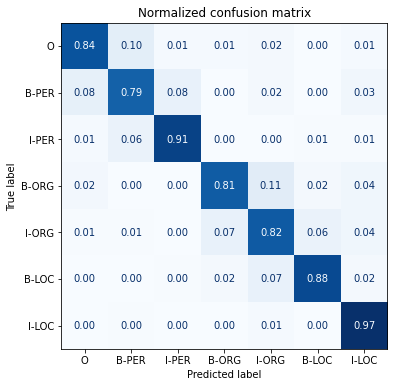

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

Let's go one level above to check the losses on sentence level. Before doing that we need to create a function to return a dataframe of tokens, labels, preds and losses.

In [ ]:
def get_samples(df):
  for _, row in df.iterrows():
    labels, preds, tokens, losses = [], [], [], []
    for i, mask in enumerate(row['attention_mask']):
      # exclude begining and ending tokens
      if i not in {0, len(row['attention_mask'])}: 
        labels.append(row['labels'][i])
        preds.append(row['predicted_label'][i])
        tokens.append(row["input_tokens"][i])
        losses.append(f"{row['loss'][i]:.2f}")
    df_tmp = pd.DataFrame({'tokens': tokens, 'labels': labels,
                           'preds': preds, 'losses': losses}).T
    yield df_tmp

Then we calculate the sum of losses and create a dataframe to show the top 3 loss terms.

In [ ]:
df['total_loss'] = df['loss'].apply(sum)
df_tmp = df.sort_values(by='total_loss', ascending=False).head(3)

We can see the Riverview historic district is mislabeled as "ORG" and "listed on" is mislabeled on "ORG" too. So we would not need to worry about the losses come from mislabeled data.

In [ ]:
for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
tokens,▁River,view,▁Historic,▁District,▁(,▁Sel,ma,▁,",",▁Alabama,...,▁,",",▁listed,▁on,▁the,▁NR,HP,▁in,▁Alabama,</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,IGN,I-ORG,...,O,IGN,B-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,...,O,O,O,O,O,B-ORG,I-ORG,O,B-LOC,I-LOC
losses,3.30,0.00,3.53,3.45,3.00,3.51,0.00,4.17,0.00,3.87,...,0.00,0.00,7.53,8.98,9.01,5.62,0.00,7.64,5.69,0.00


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
tokens,▁',▁'',▁Justin,▁Tim,ber,la,ke,▁-,▁Mirror,s,...,▁40,▁1,▁,",",▁February,▁11,▁),▁'',▁',</s>
labels,O,O,B-ORG,I-ORG,IGN,IGN,IGN,I-ORG,I-ORG,IGN,...,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,O,O,IGN
preds,O,O,B-PER,I-PER,I-PER,I-PER,I-PER,O,B-ORG,O,...,I-ORG,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,3.20,2.97,0.00,0.00,0.00,5.04,4.12,0.00,...,0.68,4.95,6.24,0.00,6.34,5.09,4.71,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
tokens,▁Power,▁of,▁Soul,▁:,▁A,▁Tribut,e,▁to,▁Jim,i,▁Hend,rix,▁'',</s>
labels,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN,O,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O,I-ORG
losses,5.59,5.70,5.90,5.34,5.78,5.51,0.00,5.47,5.35,0.00,4.96,0.00,0.00,0.00


Find all the rows that contains "()" and rank them by losses from high to low. "\u2581" is the space sign in unicode. Display top losses entries.

In [ ]:
df_tmp = df.loc[df['input_tokens'].apply(lambda x: u"\u2581(" in x)]

In [ ]:
df_tmp = df_tmp.sort_values('total_loss', ascending=False)
df_tmp

for sample in get_samples(df_tmp[:3]):
  display(sample)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
tokens,▁River,view,▁Historic,▁District,▁(,▁Sel,ma,▁,",",▁Alabama,...,▁,",",▁listed,▁on,▁the,▁NR,HP,▁in,▁Alabama,</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,IGN,I-ORG,...,O,IGN,B-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,...,O,O,O,O,O,B-ORG,I-ORG,O,B-LOC,I-LOC
losses,3.30,0.00,3.53,3.45,3.00,3.51,0.00,4.17,0.00,3.87,...,0.00,0.00,7.53,8.98,9.01,5.62,0.00,7.64,5.69,0.00


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
tokens,▁',▁'',▁Justin,▁Tim,ber,la,ke,▁-,▁Mirror,s,...,▁40,▁1,▁,",",▁February,▁11,▁),▁'',▁',</s>
labels,O,O,B-ORG,I-ORG,IGN,IGN,IGN,I-ORG,I-ORG,IGN,...,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,O,O,IGN
preds,O,O,B-PER,I-PER,I-PER,I-PER,I-PER,O,B-ORG,O,...,I-ORG,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,3.20,2.97,0.00,0.00,0.00,5.04,4.12,0.00,...,0.68,4.95,6.24,0.00,6.34,5.09,4.71,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
tokens,▁'',Ref,lec,tions,▁in,▁Blue,▁'',▁(,▁Art,▁Blake,y,▁album,▁),▁,",",▁record,ed,▁in,▁1978,</s>
labels,B-LOC,IGN,IGN,IGN,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,O,IGN,O,IGN,O,O,IGN
preds,B-ORG,B-ORG,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O,O,O,O,O,O,I-ORG
losses,3.42,0.00,0.00,0.00,5.53,5.59,5.15,5.30,5.42,5.07,0.00,5.00,4.89,0.00,0.00,0.00,0.00,0.00,0.11,0.00


# Cross-Lingual Transfer

First we need to define a function that help us to get F1 score of a particular model(trainer) on a particular dataset.

In [ ]:
def get_f1_score(trainer, dataset):
  return trainer.predict(dataset).metrics['test_f1']

Since we have multiple languages' dataset we need to train on and evaluate performance on their validation sets. Dictionaries are the best containers to save those benchmarks. So we create a defaultdict to save the F1 score info.
Get the F1 score on the English test dataset and display it to 3 decimals.

## Fine-Tune: English, Test: All

In [ ]:
f1_scores = defaultdict(dict)

f1_scores['en']['en'] = get_f1_score(trainer, panx_en_encoded['test'])
f"F1 score on English test dataset: {f1_scores['en']['en']:.3f}"

'F1 score on English test dataset: 0.787'

Define a function to automatically evaluate the performance of an arbitrary trainer of an arbitrary language on our test dataset.

In [ ]:
def evaluate_lang_performance(lang, trainer):
  panx_ds = encode_panx_dataset(panx_ch[lang])
  return get_f1_score(trainer, panx_ds['test'])

Evaluate the performance of the model (trained on English) on the Spanish and Chinese test dataset to see its power on zero-shot learning. On Spanish, the $F_1$ score is 0.643 which is pretty good considering our model has not seen the Spanish yet. But on Chinese, the $F_1$ score is only 0.257 and even lower on Japanese. This is due to the fact that English and Spanish belong to the same  Indo-European language family, while Chinese belongs to  the Sino-Tibetan family and Japanese belongs to the Japanese-Ryukyuan language family.

In [ ]:
f1_scores['en']['es'] = evaluate_lang_performance("es", trainer)
f1_scores['en']['zh'] = evaluate_lang_performance("zh", trainer)
f1_scores['en']['ja'] = evaluate_lang_performance("ja", trainer)

pd.DataFrame(f1_scores['en'], index=['F1-score'])

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

,en,es,zh,ja
F1-score,0.786944,0.654481,0.264885,0.187024


## Fine-Tune: Chinese, Test: All

In [ ]:
for lang in ['en', 'es', 'ja']:
  f1_scores['zh'][lang] = evaluate_lang_performance(lang, trainer_zh)

pd.DataFrame(f1_scores['zh'], index=['f1 score'])

,zh,en,es,ja
f1 score,0.676224,0.423575,0.509091,0.456702


## When does fine-tuning surpass zero-shot?

To determine at which point zero-shot cross-lingual transfer is superior, we will fine-tune XLM-R on training datasets of increasing sizes and track its performance.
We provide a function that automate the training on a dataset with different sample sizes, fine-tunes XLM-R on that sample and return $F_1$ scores as dataframes.

In [ ]:
def train_on_subset(dataset, num_samples):
  train_ds = dataset['train'].shuffle(42).select(range(num_samples))
  valid_ds = dataset['validation']
  test_ds = dataset['test']
  training_args.logging_steps = len(train_ds) // batch_size

  trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
  trainer.train()
  f1_score = get_f1_score(trainer, test_ds)
  return pd.DataFrame.from_dict(
      {'num_samples': [len(train_ds)], 'f1_score': [f1_score]}
  )

# initiate the dataframe
metrics_df = pd.DataFrame()

for num_samples in [250, 500, 1000, 2000, 4000]:
  metrics_df = metrics_df.append(
      train_on_subset(panx_es_encoded, num_samples), ignore_index=True
  )

Epoch,Training Loss,Validation Loss,F1
1,1.891300,1.372346,0.102032
2,1.292000,1.121574,0.296792
3,1.064300,1.025326,0.329021


Epoch,Training Loss,Validation Loss,F1
1,1.501800,0.988054,0.398459
2,0.784900,0.632049,0.574709
3,0.493200,0.539374,0.653025


Epoch,Training Loss,Validation Loss,F1
1,1.182500,0.584449,0.634911
2,0.454200,0.381542,0.753798
3,0.283300,0.367739,0.797456


Epoch,Training Loss,Validation Loss,F1
1,0.799100,0.376766,0.764531
2,0.294900,0.333822,0.805055
3,0.193500,0.325355,0.825858


Epoch,Training Loss,Validation Loss,F1
1,0.588600,0.331263,0.795257
2,0.257900,0.291558,0.839400
3,0.168200,0.295820,0.858894


We can see from the below plot that fine-tuning on Spanish reaches a similar level of performance with the zero-shot transfer from English at 500 training examples level. Then its performances will pass the zero-shot with more training examples. Keep in mind in real word, labelling process is very costly. This result will guide us in choosing which of two approaches when only a limited amount of data is available.

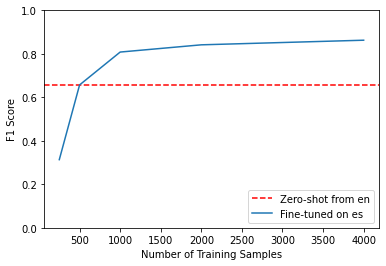

In [ ]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["en"]["es"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from en", "Fine-tuned on es"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

## Fine-Tune: English + Chinese, Test: All

English and Chinese are two representatives for the west and east. Let's create a bigger dataset by merging the two languages to see how training on this merged dataset would improve the performance of the model.

In [ ]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
  multi_corpus = DatasetDict()
  for split in corpora[0].keys():
    multi_corpus[split] = concatenate_datasets(
        [corpus[split] for corpus in corpora]
    ).shuffle(42)
  return multi_corpus

panx_en_zh_encoded = concatenate_splits([panx_en_encoded, panx_zh_encoded])

In [ ]:
training_args.logging_steps = len(panx_en_zh_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-en-zh"

trainer_en_zh = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_en_zh_encoded["train"],
    eval_dataset=panx_en_zh_encoded["validation"])

trainer_en_zh.train()

Epoch,Training Loss,Validation Loss,F1
1,0.502100,0.313026,0.675988
2,0.283100,0.272527,0.726316
3,0.193900,0.270658,0.742156


TrainOutput(global_step=1251, training_loss=0.32610605660674097, metrics={'train_runtime': 282.0738, 'train_samples_per_second': 106.355, 'train_steps_per_second': 4.435, 'total_flos': 2457672414599424.0, 'train_loss': 0.32610605660674097, 'epoch': 3.0})

Recall that if we only train the model on Chinese dataset, the $F_1$ score on Japanese the dataset is just 0.457 . We can see the performance has increased slightly to 0.474, with the assistance of training on English. It is also very surprising, the f1 score on Spanish has increased to 0.654. It seems that training with the assistance of language from a completely different system did not help improve the model. 

In [ ]:
f1_scores_en_zh = {}

for lang in langs:
  f1 = evaluate_lang_performance(lang, trainer_en_zh)
  f1_scores_en_zh[lang] = f1

pd.DataFrame(f1_scores_en_zh, index=['F1-score'])

,en,es,zh,ja
F1-score,0.785615,0.645151,0.710161,0.473732


## Fine-Tune: All, Test: All

In [ ]:
corpora = [panx_en_encoded]

for lang in langs[1:]:
  training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
  ds_encoded = encode_panx_dataset(panx_ch[lang])
  metrics = train_on_subset(ds_encoded, ds_encoded['train'].num_rows)
  f1_scores[lang][lang] = metrics['f1_score'][0]
  corpora.append(ds_encoded)

corpora_encoded = concatenate_splits(corpora)

Epoch,Training Loss,Validation Loss,F1
1,0.531700,0.328349,0.803659
2,0.231800,0.302267,0.846586
3,0.150600,0.287622,0.856959


Epoch,Training Loss,Validation Loss,F1
1,0.585400,0.346993,0.539286
2,0.310200,0.262584,0.640941
3,0.221900,0.251763,0.670861


Epoch,Training Loss,Validation Loss,F1
1,0.693400,0.430281,0.431061
2,0.419100,0.358930,0.554161
3,0.328300,0.351591,0.572391


[DatasetDict({
     train: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 5000
     })
     validation: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 2500
     })
     test: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 2500
     })
 }), DatasetDict({
     train: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 5000
     })
     validation: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 2500
     })
     test: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 2500
     })
 }), DatasetDict({
     train: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 5000
     })
     validation: Dataset({
         features: ['input_ids', 'attention_mask', 'labels'],
         num_rows: 2500
     })
     t

In [ ]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.488400,0.344808,0.679148
2,0.302300,0.283953,0.727001
3,0.220400,0.288393,0.739624


TrainOutput(global_step=2502, training_loss=0.3367523339440783, metrics={'train_runtime': 657.15, 'train_samples_per_second': 91.303, 'train_steps_per_second': 3.807, 'total_flos': 6023323115824896.0, 'train_loss': 0.3367523339440783, 'epoch': 3.0})

In [ ]:
for idx, lang in enumerate(langs):
  f1_scores['all'][lang] = get_f1_score(trainer, corpora[idx]['test'])

In [ ]:
scores_data = {
    'en': f1_scores['en'],
    'zh': f1_scores['zh'],
    'each': {lang: f1_scores[lang][lang] for lang in langs},
    'all': f1_scores['all']
}

In [ ]:
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index='Fine-tune on', columns='Evaluated on',
                         inplace=True)

In [ ]:
f1_scores_df

Evaluated on,en,es,zh,ja
Fine-tune on,,,,
en,0.7869,0.6545,0.2649,0.1870
zh,0.4236,0.5091,0.6762,0.4567
each,0.7869,0.8714,0.6762,0.5746
all,0.7803,0.8717,0.7207,0.6290


If we only fine-tune the model on English, its performance is generally good at western languages: English and Spanish, but not so good at oriental languages such as Chinese and Japanese. Vice does not, since fine-tuning on Chinese is not doing as good on Japanese, indicating underneath the similarities of written forms of both languages, there is substantial difference in grammar or syntax. Fine-tuning on all languages has improved the performance of the model on almost all languages except English. 

# Reference
[1] Tunstall, Lewis, et al. Natural Language Processing with Transformers. 1st edition. O'Reilly Media, Inc., 2022.

[2] Xtreme · Datasets at Hugging Face. 17 Feb. 2022, [huggingface.co/datasets/xtreme](huggingface.co/datasets/xtreme).

[3] XLM-R: State-of-the-art cross-lingual understanding through self-supervision. Meta AI. (n.d.). Retrieved December 1, 2022, from https://ai.facebook.com/blog/-xlm-r-state-of-the-art-cross-lingual-understanding-through-self-supervision/ 